### ゲーム木(game tree) を描く例: $\circ \times$ ゲーム (Tic-tac-toe)

#### パッケージのインストール
- Colab での実行について: 更新されたパッケージを有効にするには，インストール後に [RESTART RUNTIME] をクリックする

In [3]:
import sys
from IPython.core.getipython import get_ipython


is_colab = 'google.colab' in sys.modules

try:
    import graphviz
    LEAST_MAJOR_VER_REQUIRED = 0
    LEAST_MINOR_VER_REQUIRED = 16
    maj_ver, min_ver = map(int, graphviz.__version__.split('.')[:2])
    if not (maj_ver >= LEAST_MAJOR_VER_REQUIRED and min_ver >= LEAST_MINOR_VER_REQUIRED):
        raise ModuleNotFoundError()

except ModuleNotFoundError as e:
    print(e)
    print('Installing...')

    if is_colab:
        get_ipython().system('pip install -U graphviz')


try:
    import lxml

except ModuleNotFoundError as e:
    print(e)
    print('Installing...')

    if is_colab:
        get_ipython().system('pip install lxml')



#### ゲーム木の描画
- 基本的なプログラムの構造は ch09_tic_tac_toe_count.ipynb と同様
- play() の再帰呼び出しに付随して，対応するゲームの状態のノードを追加することによりツリー構造を構築する
- ツリー構造の作図のために graphviz を用いる
- ゲーム木のノード内部にボードを描くには lxml パッケージを利用して HTML の table を構築する

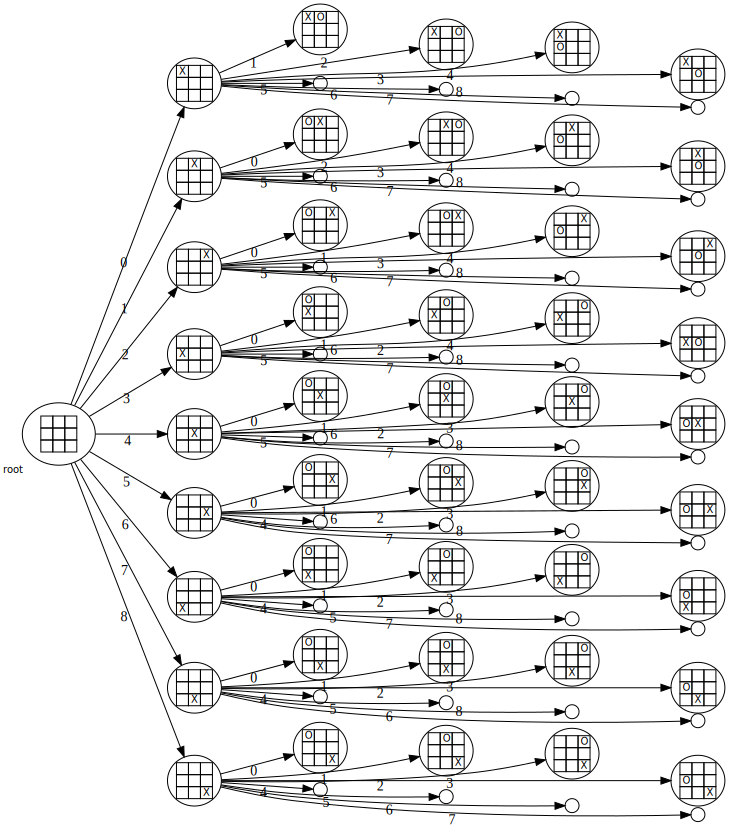

In [2]:
import itertools
import copy
import os
import contextlib

import lxml.html.builder as E
import lxml.html
import graphviz
import IPython.display

NROWS = 3
NCOLS = 3
NUM_CELLS = NROWS*NCOLS
statistics = {'won by X': 0, 'won by O': 0, 'draw': 0}
board_dict = {'won by X': [], 'won by O': [], 'draw': []}

GAME_OVER = 0
ABNORMAL_GAME = 1
GAME_CONTINUED = 2

TREE_DEPTH_TO_SHOW = 2

def convert_histories_to_html_table(histories):
    tbl = E.TABLE()

    for i in range(NROWS):
        tr = E.TR()
        tbl.append(tr)
        for j in range(NCOLS):
            td = E.TD()
            tr.append(td)
            idx = i*NCOLS + j

            if idx in histories[0]:
                td.text = 'X'
            elif idx in histories[1]:
                td.text = 'O'
            else:
                td.text = ' '
            sz = '12'
            td.set('width', sz)
            td.set('height', sz)
            td.set('fixedsize', 'TRUE')

    tbl.set('cellspacing', '0')    
    tbl.set('cellpadding', '0')    
    tbl.set('border', '0')    
    tbl.set('cellborder', '1')    
    return tbl

def game_status(histories):
    final_states = [ 
        {0, 1, 2}, # horizontal
        {3, 4, 5},
        {6, 7, 8},

        {0, 3, 6}, # vertical
        {1, 4, 7},
        {2, 5, 8},

        {0, 4, 8}, # diagonal
        {2, 4, 6},
    ]
    symbol = ['O', 'X']
    if len(histories[0]) == len(histories[1]):
        last_move = 1
        next_move = 0
    else:
        last_move = 0
        next_move = 1

    for s in final_states:
        if s.issubset(set(histories[last_move])):
            print(f'{symbol[last_move]} won the game')
            statistics[f'won by {symbol[last_move]}'] += 1
            board_dict[f'won by {symbol[last_move]}'].append(histories)
            return GAME_OVER
        if s.issubset(set(histories[next_move])):
            print('abnormal game status was detected')
            raise RuntimeError('abnormal game status was detected')
            # return ABNORMAL_GAME

    # draw
    if (len(histories[0]) + len(histories[1])) == NUM_CELLS:
        print('Draw')
        statistics['draw'] += 1
        board_dict['draw'].append(histories)
        return GAME_OVER

    return GAME_CONTINUED

def get_last_action(histories):
    if len(histories[0]) > len(histories[1]):
        return histories[0][-1]
    else:
        return histories[1][-1]

class GameTree:
    """
    ゲームの木を表現するクラス
    """

    def __init__(self):
        if True:
            self._graph = graphviz.Digraph('G', filename='ttt_game_tree.gv', engine='dot', format='pdf')
        else:
            self._graph = graphviz.Digraph('G', filename='ttt_game_tree.gv', engine='dot', format='png')
        self._id_gen = itertools.count()
        self._children = {}
        self._num_boards_per_sibling = 4
        self.reset_attrs(self._graph)

    def reset_attrs(self, graph):
        graph.attr('edge', splines='spline')
        graph.attr('node', fontname='Sans-serif')
        graph.attr('node', fontsize='10')
        graph.attr('graph', ranksep='1.0')
        graph.attr('graph', nodesep='0.0')
        graph.attr('graph', rankdir='LR')
        graph.attr('graph', margin='0')
        graph.attr('graph', packmode='graph')
        return graph

    def append_node(self, histories, parent_id=None, show_board=False):
        tbl = convert_histories_to_html_table(histories)
        label = f"<{lxml.html.tostring(tbl, encoding='unicode')}>"

        id = f'H{next(self._id_gen)}' 

        if parent_id == None: # creating the root
            if show_board:
                self._graph.node(id, label, xlabel='root')
            else:
                self._graph.node(id, label=' ', shape='circle', fixedsize='true', width='1',
                                height='1', margin='0', xlabel='root')

        else:
            if self._children.get(parent_id) == None:
                self._children[parent_id] = 0
            else:
                self._children[parent_id] += 1

            if show_board:
                if parent_id != 'H0':
                    if self._children[parent_id] < self._num_boards_per_sibling:
                        self._graph.node(id, label, margin='0') #, rank='min'
                    else:
                        self._graph.node(id, label=' ', shape='circle', fixedsize='true', width='0.2', height='0.2', margin='0')
                else:
                    self._graph.node(id, label, margin='0') #, rank='min'
            else:
                self._graph.node(id, label=' ', shape='circle', fixedsize='true', width='1',
                                height='1', margin='0')

            act = get_last_action(histories)

            self._graph.edge(parent_id, id, xlabel=f'{act}')

        return id

    def render(self):
        if True:
            # 図が縦長になりすぎないように，同一レベルのノードが一直線に並ぶルールを緩和して
            # ツリー構造を描く
            g = self._graph.unflatten(stagger=4, fanout=True)
            g.render()
            self._unflatten_graph = g

        else:
            self._graph.render()
            self._unflatten_graph = self._graph

    def display(self):
        IPython.display.display(self._unflatten_graph)




def play(histories, empty_cells, tree, parent_id):
    n_empty_cells = len(empty_cells)

    if n_empty_cells < NUM_CELLS - (TREE_DEPTH_TO_SHOW - 1):
        return

    if game_status(histories) in {GAME_OVER, ABNORMAL_GAME}:
        return

    move = (n_empty_cells + 1) % 2

    for c in empty_cells:
        tmp_histories = copy.deepcopy(histories)
        tmp_histories[move].append(c)
        tmp_empty_cells = empty_cells - {c}

        hist_id = tree.append_node(tmp_histories, parent_id, show_board=True)

        play(tmp_histories, tmp_empty_cells, tree, hist_id)




histories = [[], []] # for player 'X' and 'O'
empty_cells = set(range(NUM_CELLS))

# suppress warnings about cell size with contextlib
with contextlib.redirect_stderr(open(os.devnull, 'w')) as f:
# if True: 
    tree = GameTree()
    root_id = tree.append_node(histories, show_board=True)

    play(histories, empty_cells, tree, root_id)

    tree.render()
    tree.display()




#### 描画した図のダウンロード

In [ ]:
import os
import ipywidgets
import functools
import IPython.display
import sys

is_colab = 'google.colab' in sys.modules

def do_download(path, dummy_button):
    import google.colab.files
    google.colab.files.download(path)

exts = ['pdf', 'png']

for f in os.listdir():
    f_ext = f.split(os.path.extsep)[-1]

    if not os.path.isdir(f) and f_ext in exts:
        fp = os.path.abspath(f)
        
        if is_colab:
            btn = ipywidgets.Button(description=f'download: {f}', 
                                    layout={'width': '50%'})
            btn.on_click(functools.partial(do_download, fp))
            IPython.display.display(btn)

        else:
            IPython.display.display(IPython.display.FileLink(f))

#### 解説
- 以下の解説のセルを正常に実行するには Notebook の最初から順にセルを実行しておく必要がある。

ゲームの木(ツリー構造)は有向グラフ(directed graph)というグラフ構造の一種であり，graphviz では，
[`graphviz.Digraph`](https://graphviz.readthedocs.io/en/stable/api.html#digraph)
で描画できる。

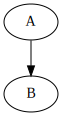

In [3]:
g = graphviz.Digraph('G', filename='tmp.gv')
g.node('A') # 指定した ID のノードを作る
g.node('B') # 指定した ID のノードを作る
g.edge('A', 'B') # 一つ目の ID のノードから二つ目の ID のノードに向かうエッジを作る。
IPython.display.display(g)

ノードのラベルは，[HTML のサブセット](https://www.graphviz.org/doc/info/shapes.html#html)で記述できる。

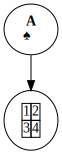

In [4]:
g = graphviz.Digraph('G', filename='tmp2.gv')
g.node('A', label='< <b>A</b> <br/> &spades; >') 
g.node('B', label='''<
    <table cellspacing="0" cellpadding="0" border="0" cellborder="1" width="12" height="12"> 
    <tr> <td>1</td> <td>2</td> </tr> 
    <tr> <td>3</td> <td>4</td> </tr> 
    </table>
    >''')
g.edge('A', 'B') 
IPython.display.display(g)

この Notebook の最初のセルで定義した `convert_histories_to_html_table()` は，HTML の表の生成を簡潔に記述するため，
lxml パッケージを用いている。

[`Digraph.attr('node', ...)`](https://graphviz.readthedocs.io/en/stable/api.html#graphviz.Digraph.attr) 
は各ノードのデフォルトの設定([attributes](https://www.graphviz.org/doc/info/attrs.html))を変更する。

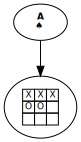

In [5]:
g = graphviz.Digraph('G', filename='tmp2.gv')
g.attr('node', fontname='Sans-serif', fontsize='9') 

g.node('A', label='< <b>A</b> <br/> &spades; >') 

moves_by_x = (0, 1, 2)
moves_by_o = (3, 4)
histories = [moves_by_x, moves_by_o]
tbl = convert_histories_to_html_table(histories)
lb = f"<{lxml.html.tostring(tbl, encoding='unicode')}>"

g.node('B', label=lb)
g.edge('A', 'B') 
IPython.display.display(g)

[`contextlib.redirect_stderr`](https://docs.python.org/ja/3/library/contextlib.html#contextlib.redirect_stderr) は標準エラーオブジェクトへの出力を別のオブジェクトへの出力に横流し(redirect)する。
これによって，無視したいエラーメッセージが出力セルに表示されないようになる。

In [6]:
sys.stderr.write('表示される: message')
with contextlib.redirect_stderr(open(os.devnull, 'w')) as f:
    sys.stderr.write('無視されない: mesage')

表示される: message

#### 参考文献
- [Graphviz (ソフトウェア) の公式サイト](https://www.graphviz.org/)
  - Graphviz はグラフ構造を描画するツールであり，入力として一種の[ドメイン特化言語](https://ja.wikipedia.org/wiki/%E3%83%89%E3%83%A1%E3%82%A4%E3%83%B3%E5%9B%BA%E6%9C%89%E8%A8%80%E8%AA%9E)([DOT言語](https://ja.wikipedia.org/wiki/DOT%E8%A8%80%E8%AA%9E))で書かれたソースコードを与える必要がある。

- [graphviz パッケージのオンラインドキュメント](https://graphviz.readthedocs.io/en/stable/)
  - Python 用の graphviz パッケージは次のような順序で機能する
    - グラフ構造に対応するデータ構造を構築する
    - 構築したデータ構造を DOT 言語のソースファイルに変換する
    - DOT 言語のソースファイルを処理する Graphviz のコマンド (dot, unflatten, 等)を呼び出す

- [lxml パッケージの公式サイト](https://lxml.de/)